In [ ]:
#hide
# Have to do this to avoid the performance degradation reported in https://forums.fast.ai/t/performance-degradation-between-fastai-2-2-5-and-2-2-7/86069
!pip install fastai==2.2.5

In [129]:
from fastai.vision.all import *

In [152]:
path = untar_data(URLs.PASCAL_2007)

In [153]:
def get_x(r): return (path/"train") / r["fname"]
def get_y(r): return r["labels"].split(" ")
def splitter(df):
  train = df.index[~df["is_valid"]].tolist()
  valid = df.index[df["is_valid"]].tolist()
  return train,valid
  
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                         get_x=get_x, 
                         get_y=get_y, 
                         splitter=splitter,
                         item_tfms= RandomResizedCrop(128, min_scale=0.35))

In [154]:
df = pd.read_csv(path / "train.csv")
dls = dblock.dataloaders(df)

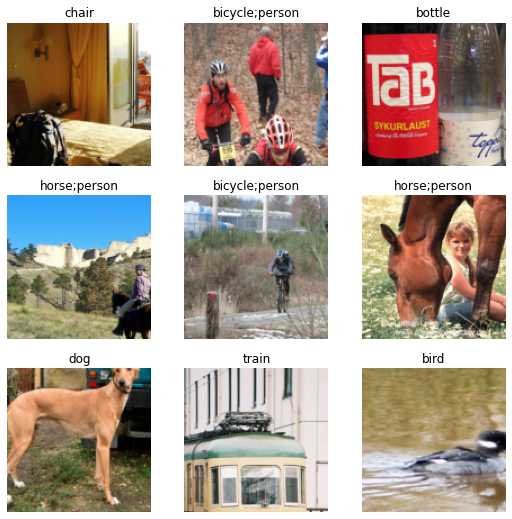

In [155]:
dls.show_batch()

## CNN Learner

This is pretty much exactly what is done in the book:

In [169]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi])
learn.fine_tune(3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.977620,0.725415,0.580797,00:33
1,0.791657,0.435256,0.840558,00:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.469540,0.308106,0.922868,00:34
1,0.351693,0.185275,0.953805,00:34
2,0.276099,0.173903,0.955299,00:34


95% accuracy was great for the other datasets, but it doesn't really say much about how well we do in this problem. Even a model that just predicts 0 for every label (see below) gets 92% accuracy.

## Naive baseline

In [158]:
class AllZeroModel(nn.Module):
    def __init__(self):
        super(AllZeroModel, self).__init__()

    def forward(self, x):
        output = torch.zeros(x.shape[0], 20).to("cuda:0")
        return output

In [159]:
model = AllZeroModel()

In [160]:
accuracy_no_sigmoid = partial(accuracy_multi, sigmoid=False)
dumb_learner = Learner(dls, AllZeroModel(), metrics=[accuracy_no_sigmoid])

In [ ]:
_, multi_accuracy = dumb_learner.validate()

In [165]:
print(f"Multi Accuracy: {multi_accuracy}")

Multi Accuracy: 0.922390341758728


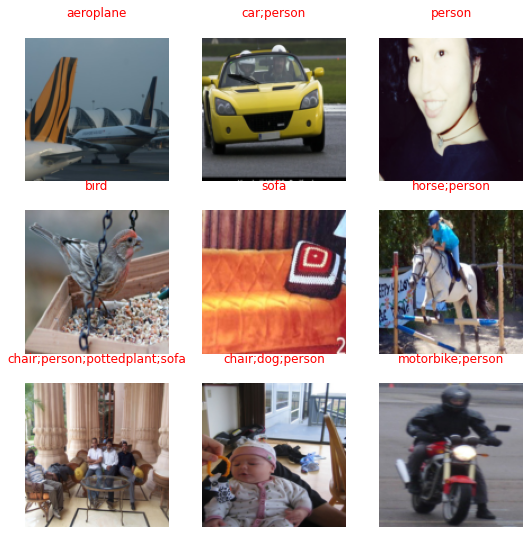

In [144]:
dumb_learner.show_results()

## Attempt to use APScoreMulti

In [170]:
learn = cnn_learner(dls, resnet34, metrics=[APScoreMulti])
learn.fine_tune(3, freeze_epochs=2)

epoch,train_loss,valid_loss,APScoreMulti,time


RuntimeError: ignored

## GUI to interact with model

In [130]:
from ipywidgets import FileUpload, Output, Label, VBox, Button

In [149]:
upload = FileUpload()
out_pl = Output()
lbl_pred = Label()
btn_run = Button(description="classify")

def on_click_classify(change):
  img = PILImage.create(upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128, 128))
  pred, pred_idx, probs = learn.predict(tensor(img))
  lbl_pred.value = f'Prediction {pred}, Probability: {probs[pred_idx]}'

btn_run.on_click(on_click_classify)

In [150]:
VBox([upload, btn_run, out_pl, lbl_pred])

In [ ]:
learn.predict(upload.data[-1])
print(pred)
print(list(zip(dls.vocab, probs)))